### Project: Knowledge Based Recommendation System

#### DSC 630

Taniya Adhikari 15/24/2021

In [1]:
from bs4 import BeautifulSoup as BS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import seaborn as sns
import requests

import warnings; warnings.simplefilter('ignore')

import re
from re import sub
import multiprocessing
from unidecode import unidecode

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors


from time import time 
from collections import defaultdict

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
import textblob

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bibek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Collection

In [2]:
baseurl = "https://sokoglam.com"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'}

In [3]:
k = requests.get('https://sokoglam.com/collections/skincare').text
soup=BS(k,'html.parser')
productlist = soup.find_all("div",{"class":"product-grid-item"})

In [5]:
productlinks = []
for product in productlist:
    link = product.find('a').get('href')
    productlinks.append(baseurl + link)

1

In [6]:
len(productlinks)

299

In [7]:
data=[]
for link in productlinks:
    f = requests.get(link,headers=headers).text
    hun=BS(f,'html.parser')
    try:
        i=hun.find("div",{"class":"review-stars"})
        product_id = i.find("div").get("data-product-id")
    except:
        product_id = None
        
    try:
        name=hun.find("h1",{"class":"pdp__product-title"}).text.replace('\n',"")
    except:
        name = None
        
    try:
        brand=hun.find("h3",{"class":"pdp__product-vendor"}).text.replace('\n',"")
    except:
        brand = None
    
    try:
        price=hun.find("span",{"class":"pdp-product__price--sale ProductPrice"}).text.replace('\n',"")
    except:
        price = None

    try:
        content1=hun.find("section",{"id":"content1"})
        descp=content1.find("div",{"class":"pdp-tab-content"}).text.replace('\n',"")
    except:
        descp = None

    product = {"product_ID":product_id,"product_name":name, "product_brand":brand, "price": price, "product_description":descp, }

    data.append(product)

In [24]:
meta_df = pd.DataFrame(data)

In [25]:
meta_df.shape

(299, 5)

Removing products that are either body or hair product, makeup products that is not typical skincare, books from the website, clothes

In [26]:
remove = ['Hair', 'Shampoo', 'Body', 'Foot', 'Hand']
for item in remove:
    for index, row in meta_df.iterrows():
        x = str(row['product_name'])
        if item in x:
            meta_df.drop(index, inplace=True)
        else:
            None

In [27]:
remove = ['Hair', 'Shampoo', 'Body', 'Foot', 'Hand']
for item in remove:
    for index, row in meta_df.iterrows():
        x = str(row['product_description'])
        if item in x:
            meta_df.drop(index, inplace=True)
        else:
            None

In [28]:
remove = ['Set', 'Kit', 'Routine', 'Collection', 'Duo Trial', 'Treatment Duo', 'Balancing Duo', 'Cleansing Duo']
for item in remove:
    for index, row in meta_df.iterrows():
        x = str(row['product_name'])
        if item in x:
            meta_df.drop(index, inplace=True)
        else:
            None

In [29]:
remove = ['Liner', 'Blush', 'Primer', 'Lip Luminizer', 'Lip Lacquer', 'Eyeliner', 'Mascara', "Multistick", "Mini", "Lashes"]
for item in remove:
    for index, row in meta_df.iterrows():
        x = str(row['product_name'])
        if item in x:
            meta_df.drop(index, inplace=True)
        else:
            None

In [30]:
remove = ['Cotton', 'Paper', 'Book', 'Baseball Cap', 'Sweatshirt']
for item in remove:
    for index, row in meta_df.iterrows():
        x = str(row['product_name'])
        if item in x:
            meta_df.drop(index, inplace=True)
        else:
            None

In [31]:
meta_df.shape

(237, 5)

Adding a product type to the dataframe

In [32]:
meta_df['product_type'] = None

In [33]:
def product_type(items, word, df):
    for item in items:
        for index, row in df.iterrows():
            if row['product_type'] == None:
                x = str(row['product_name'])
                if item in x:
                    row['product_type'] = word
                else:
                    None

In [34]:
items = ['Eye']
product_type(items, 'Eye Treatment', meta_df)

In [35]:
items = ['Lip']
product_type(items, 'Lip Treatment', meta_df)

In [36]:
add = ['Sun Cream', 'Sun Essence', 'Sunscreen', 'UV', 'SPF', "I'm Safe For Sensitive Skin", 'Suncream']
for item in add:
    for index, row in meta_df.iterrows():
        if row['product_type'] == None:
            x = str(row['product_name'])
            if item in x:
                row['product_type'] = 'Sun Protection'
            else:
                None

In [37]:
items = ['Sheet Mask']
product_type(items, 'Sheet Mask', meta_df)

In [38]:
items = ['Mask']
product_type(items, 'Mask', meta_df)

In [39]:
items = ['Serum', 'Ampoule']
product_type(items, 'Serum', meta_df)

In [40]:
items = ['Essence', 'Mist']
product_type(items, 'Essence', meta_df)

In [41]:
items = ['Cleansing', 'Cleanser', 'Foam']
product_type(items, 'Cleanser', meta_df)

In [42]:
items = ['Toner', 'Toning', 'Water']
product_type(items, 'Toner', meta_df)

In [43]:
items = ['Lotion', 'Cream', 'Moisturizer', 'Emulsion']
product_type(items, 'Moisturizer', meta_df)

In [44]:
items = ['Peel', 'Peeling', 'Scrub', 'Exfoliat', 'Pad']
product_type(items, 'Exfoliator', meta_df)

In [45]:
for index, row in meta_df.iterrows():
    if row['product_type'] == None:
        x = str(row['product_name'])
        row['product_type'] = 'Other/Spot Treatments'

In [46]:
meta_df.to_csv('productlist.csv')

In [34]:
session = requests.Session()
#productToReviews = [] #empty dictionary
productReviews = []
for index, row in meta_df.iterrows():
    requestUrl = 'https://staticw2.yotpo.com/batch/app_key/kILjLgKH3AFJKWu0W8HoD8nuvs72obqsSPmWjHiG/domain_key/{}/widget/reviews'.format(row.product_ID)
    recordExists = True
    i = 1
    while(recordExists):
        methodBody = '[{"method":"reviews","params":{"pid":' + row.product_ID + ',"order_metadata_fields":{},"index":0,"element_id":"1","data_source":"default","page":' + str(i) +',"host-widget":"main_widget","is_mobile":false,"pictures_per_review":10}}]'
        #print(methodBody)
        x = session.post(url, data = {'methods': methodBody})
        if('be the first to write a review' in x.text):
            #print("no record")
            recordExists = False
        else:
            y = json.loads(x.text)
            soup=BS(y[0]["result"],'html.parser')
            reviewList = soup.find_all("div",{"class":"content-review"})
            for review in reviewList:
                s = BS(str(review),'html.parser')
                r = s.find("div").text.strip()
                if(len(r)):
                    productReviews.append({"product_id": row.product_ID, "review": r})
            i += 1
reviewDataFrame = pd.DataFrame.from_records(productReviews)

1

In [436]:
reviewDataFrame.to_csv('productReviews.csv')

### Data Preparation

#### Data Frame 1 Product List

In [47]:
productList_df = pd.read_csv("productlist.csv")

In [48]:
productList_df.head(3)

,Unnamed: 0,product_ID,product_name,product_brand,price,product_description,product_type
0,0,6562638659653,VITALIFT-A,Dr. Different,$42,This night-time skin treatment is ideal for th...,Other/Spot Treatments
1,1,6562639675461,VITALIFT-A Forte,Dr. Different,$52,Those that need an extra boost to smooth out f...,Other/Spot Treatments
2,2,6562640429125,VITALIFT-A Eye & Neck,Dr. Different,$40,For those looking to target fine lines and wri...,Eye Treatment


In [49]:
productList_df = pd.read_csv("productlist.csv", index_col=0)

In [50]:
productList_df.head(3)

,product_ID,product_name,product_brand,price,product_description,product_type
0,6562638659653,VITALIFT-A,Dr. Different,$42,This night-time skin treatment is ideal for th...,Other/Spot Treatments
1,6562639675461,VITALIFT-A Forte,Dr. Different,$52,Those that need an extra boost to smooth out f...,Other/Spot Treatments
2,6562640429125,VITALIFT-A Eye & Neck,Dr. Different,$40,For those looking to target fine lines and wri...,Eye Treatment


In [51]:
def clean_currency(x):
    
    #If the value is a string, then remove currency symbol and delimiters
    #otherwise, the value is numeric and can be converted
    
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

In [52]:
productList_df['price'] = productList_df['price'].apply(clean_currency).astype('float')
productList_df = productList_df.rename(columns={"product_ID": "product_id"})

In [53]:
productList_df.head(3)

,product_id,product_name,product_brand,price,product_description,product_type
0,6562638659653,VITALIFT-A,Dr. Different,42.0,This night-time skin treatment is ideal for th...,Other/Spot Treatments
1,6562639675461,VITALIFT-A Forte,Dr. Different,52.0,Those that need an extra boost to smooth out f...,Other/Spot Treatments
2,6562640429125,VITALIFT-A Eye & Neck,Dr. Different,40.0,For those looking to target fine lines and wri...,Eye Treatment


In [56]:
X = productList_df[['product_id','product_type','product_brand', 'price']]

In [57]:
X.to_csv('prod_descR.csv')

#### Data Frame 2 Product Reviews

In [203]:
productReviews_df = pd.read_csv("productReviews.csv", index_col=0)

In [204]:
productReviews_df[['product_id','review']].head(3)

,product_id,review
0,4669755719749,This makes my skin smooth and soft and is ligh...
1,4669755719749,Love the silky texture. It's very lightweight ...
2,4669755719749,I’ve been trying to find a moisturizer that wo...


In [205]:
productReviews_df.iloc[2,1]

'I’ve been trying to find a moisturizer that would not dry out my skin for months. Especially while wearing a mask. This product does much better than lots of others I have tried. Thank you'

Remove Whitespace

In [206]:
def no_whitespace(string):
    return string.strip()

In [207]:
# stripping white space from all column type as object
def clean_string(df):
    
    for col in df.columns:
        if df[col].dtype == np.object:
            new = '{}_new'.format(col)
            df[new] = df[col].apply(no_whitespace)
            df[col] = df[new]
            df = df.drop(columns=[new])
    return df


productReviews_df = clean_string(productReviews_df)
productReviews_df.head(2)

,product_id,review
0,4669755719749,This makes my skin smooth and soft and is ligh...
1,4669755719749,Love the silky texture. It's very lightweight ...


In [208]:
from itertools import groupby

In [209]:
def text_w_punc(text):
    pattern = r'[^A-Za-z ]'
    regex = re.compile(pattern)
    text = regex.sub(' ', text)
    return text

In [210]:
import string

In [211]:
def pre_processing1(df):
    # converting all text to lowercase
    df["review_sentiment"] = df["review"].str.lower()
    
    # removing punctuation using string.punctuations and join()
    df["review_sentiment"] = df["review_sentiment"].apply(lambda x: "".join([i for i in x if i not in string.punctuation]))
    df['review_sentiment'] = df['review_sentiment'].apply(lambda x: text_w_punc(x))    
    
    return df


In [212]:
productReviews_df = pre_processing1(productReviews_df)

In [213]:
productReviews_df.shape

(15040, 3)

Deleting any reviews that includes hi or sorry words, because those are replies from the seller

In [214]:
remove = ['Hi ', 'hi ', 'sorry', 'Sorry']
for item in remove:
    for index, row in productReviews_df.iterrows():
        x = str(row['review_sentiment'])
        if item in x:
            productReviews_df.drop(index, inplace=True)
        else:
            None

Removing Stop words for (td-idf and BOW model)

In [215]:
stop = stopwords.words('english')   

# remove stop words for bag of word model and td-idf

productReviews_df['stopwords'] = productReviews_df["review_sentiment"].apply(lambda x: len([i for i in x.split() if i in stop]))
productReviews_df["review_clean"]= productReviews_df["review_sentiment"].apply(lambda x: " ".join(i for i in x.split() if i not in stop))
productReviews_df['stopwords'] = productReviews_df['review_clean'].apply(lambda x: len([i for i in x.split() if i in stop]))
del productReviews_df['stopwords']


In [216]:
productReviews_df.shape

(14562, 4)

Lemmatization

In [217]:
from nltk import pos_tag

In [220]:
text_list = productReviews_df['review_clean'].tolist()

tagged_texts = []

# tag each word
for text in text_list:
    text_tag = pos_tag(word_tokenize(text))
    tagged_texts.append(text_tag)

In [221]:
productReviews_df['pos_tags'] = tagged_texts

In [222]:
productReviews_df.head(3)

,product_id,review,review_sentiment,review_clean,pos_tags
0,4669755719749,This makes my skin smooth and soft and is ligh...,this makes my skin smooth and soft and is ligh...,makes skin smooth soft lightweight absorbs qui...,"[(makes, VBZ), (skin, JJ), (smooth, JJ), (soft..."
1,4669755719749,Love the silky texture. It's very lightweight ...,love the silky texture its very lightweight bu...,love silky texture lightweight hydrating leave...,"[(love, VB), (silky, JJ), (texture, NN), (ligh..."
2,4669755719749,I’ve been trying to find a moisturizer that wo...,i ve been trying to find a moisturizer that wo...,trying find moisturizer would dry skin months ...,"[(trying, VBG), (find, NN), (moisturizer, NN),..."


In [ ]:
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

In [223]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
productReviews_df['wordnet_pos'] = productReviews_df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
productReviews_df.head(3)

,product_id,review,review_sentiment,review_clean,pos_tags,wordnet_pos
0,4669755719749,This makes my skin smooth and soft and is ligh...,this makes my skin smooth and soft and is ligh...,makes skin smooth soft lightweight absorbs qui...,"[(makes, VBZ), (skin, JJ), (smooth, JJ), (soft...","[(makes, v), (skin, a), (smooth, a), (soft, a)..."
1,4669755719749,Love the silky texture. It's very lightweight ...,love the silky texture its very lightweight bu...,love silky texture lightweight hydrating leave...,"[(love, VB), (silky, JJ), (texture, NN), (ligh...","[(love, v), (silky, a), (texture, n), (lightwe..."
2,4669755719749,I’ve been trying to find a moisturizer that wo...,i ve been trying to find a moisturizer that wo...,trying find moisturizer would dry skin months ...,"[(trying, VBG), (find, NN), (moisturizer, NN),...","[(trying, v), (find, n), (moisturizer, n), (wo..."


In [224]:
wnl = WordNetLemmatizer()
productReviews_df['lemmatized'] = productReviews_df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
productReviews_df.head(3)

,product_id,review,review_sentiment,review_clean,pos_tags,wordnet_pos,lemmatized
0,4669755719749,This makes my skin smooth and soft and is ligh...,this makes my skin smooth and soft and is ligh...,makes skin smooth soft lightweight absorbs qui...,"[(makes, VBZ), (skin, JJ), (smooth, JJ), (soft...","[(makes, v), (skin, a), (smooth, a), (soft, a)...","[make, skin, smooth, soft, lightweight, absorb..."
1,4669755719749,Love the silky texture. It's very lightweight ...,love the silky texture its very lightweight bu...,love silky texture lightweight hydrating leave...,"[(love, VB), (silky, JJ), (texture, NN), (ligh...","[(love, v), (silky, a), (texture, n), (lightwe...","[love, silky, texture, lightweight, hydrate, l..."
2,4669755719749,I’ve been trying to find a moisturizer that wo...,i ve been trying to find a moisturizer that wo...,trying find moisturizer would dry skin months ...,"[(trying, VBG), (find, NN), (moisturizer, NN),...","[(trying, v), (find, n), (moisturizer, n), (wo...","[try, find, moisturizer, would, dry, skin, mon..."


In [225]:
def listToString(s): 
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

In [226]:
productReviews_df["review_similarity"]= productReviews_df["lemmatized"].apply(lambda x: " ".join(i for i in x))

In [227]:
productReviews_df.head(3)

,product_id,review,review_sentiment,review_clean,pos_tags,wordnet_pos,lemmatized,review_similarity
0,4669755719749,This makes my skin smooth and soft and is ligh...,this makes my skin smooth and soft and is ligh...,makes skin smooth soft lightweight absorbs qui...,"[(makes, VBZ), (skin, JJ), (smooth, JJ), (soft...","[(makes, v), (skin, a), (smooth, a), (soft, a)...","[make, skin, smooth, soft, lightweight, absorb...",make skin smooth soft lightweight absorbs quickly
1,4669755719749,Love the silky texture. It's very lightweight ...,love the silky texture its very lightweight bu...,love silky texture lightweight hydrating leave...,"[(love, VB), (silky, JJ), (texture, NN), (ligh...","[(love, v), (silky, a), (texture, n), (lightwe...","[love, silky, texture, lightweight, hydrate, l...",love silky texture lightweight hydrate leaf sk...
2,4669755719749,I’ve been trying to find a moisturizer that wo...,i ve been trying to find a moisturizer that wo...,trying find moisturizer would dry skin months ...,"[(trying, VBG), (find, NN), (moisturizer, NN),...","[(trying, v), (find, n), (moisturizer, n), (wo...","[try, find, moisturizer, would, dry, skin, mon...",try find moisturizer would dry skin month espe...


In [ ]:
productReviews_df= productReviews_df.reset_index(drop = True)

In [ ]:
productReviews_df.shape

In [ ]:
productReviews_df

#### Fake review detection

50 most common words

In [ ]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in productReviews_df.iterrows():
    c = Counter(row['review_similarity'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common()]
common_words_counts = [word[1] for word in aggregate_counter.most_common()]

In [ ]:
common_word = pd.DataFrame(list(zip(common_words, common_words_counts)),columns =['Word', 'Freq'])
common_word.to_csv('common_word.csv')

No word Embeddings because we are not trying to find the contextual meaning

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create array with each text
data_arr = np.array(productReviews_df['review_similarity'].values.astype("U"))

# Create the tf-idf feature matrix
tfidf = TfidfVectorizer()
feature = tfidf.fit_transform(data_arr)

# Show feature matrix
feature

In [ ]:
#create dataframe
X=pd.DataFrame(feature.toarray())
tfidf2 = X.values.tolist()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(feature)
Y=pd.DataFrame(cosine_sim)

#### Checking if there is any similar reviews

In [ ]:
for col in Y.columns:
    if any(Y[col] > 80):
        print("True")       

Fuzzy Matching for Feature Extraction from revies and User preference

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


features = productReviews_df["review_similarity"].tolist() 
CountVec = CountVectorizer()
#transform
Count_data = CountVec.fit_transform(features)
Count_data

In [ ]:
#create dataframe
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())

In [ ]:
words = pd.DataFrame(cv_dataframe.idxmax(1),columns=['word'])

In [ ]:
from fuzzywuzzy import process, fuzz

In [ ]:
def token_fuzzy(df, percent, scorer):
    
    # unique industry lists
    unique_word = df['word'].unique().tolist()
    sorted(unique_word)
    
    '''Token Ratio'''
    #Create tuples of industries, matched industries, and the score of token sort
    score = [(x,) + i
             for x in unique_word 
             for i in process.extract(x, unique_word, scorer=scorer)]

    #Create a dataframe from the tuples
    similarity = pd.DataFrame(score, columns=['word','match','score'])

    # because this will have repitative pairs, we will remove duplicated pairs from this
    similarity['sorted_word'] = np.minimum(similarity['word'], similarity['match'])
    
    # Token high score
    high_score = token_high(similarity, percent)
    
    
    return similarity, high_score

In [ ]:
def token_high(df, percent):
    
    # create a subset dataframe with higher percent match values
    x = percent+2
    high_score = df[(df['score'] >= percent) &
                    (x > df['score']) &
                    (df['word'] !=  df['match']) &
                    (df['sorted_word'] != df['match'])]
    
    # Drop the representative value column
    high_score = high_score.drop('sorted_word',axis=1).copy()
    
    return high_score

In [ ]:
similarity, high_score = token_fuzzy(words, 95, fuzz.token_sort_ratio)
high_score.groupby(['word','score']).agg({'match': ', '.join}).sort_values(['score'], ascending=False)

# create dictionary
match_dict = dict(zip(high_score.match, high_score.word))
match_dict

In [130]:
match_dict['moisturizers'] = 'moisturize'
match_dict['fragranced'] = 'fragrance'
match_dict['afterwards'] = 'afterward'
match_dict['exfoliators'] = 'exfoliator'
match_dict['moisturizes'] = 'moisturize'
match_dict['moisturizer'] = 'moisturize'

In [131]:
words["word"].replace(match_dict, inplace=True)

In [132]:
similarity, high_score = token_fuzzy(words, 93, fuzz.token_sort_ratio)
high_score.groupby(['word','score']).agg({'match': ', '.join}).sort_values(['score'], ascending=False)
# create dictionary
match_dict = dict(zip(high_score.match, high_score.word))
match_dict

{'favorites': 'favorite',
 'breakouts': 'breakout',
 'cleanser': 'cleaner',
 'hydrated': 'hydrate',
 'believer': 'believe',
 'brightens': 'brighten',
 'absored': 'absorbed',
 'exellent': 'excellent',
 'collagen': 'collage',
 'loveeeee': 'loveeee',
 'delivers': 'deliver',
 'acnewell': 'acewell',
 'cleansing': 'cleaning',
 'complaint': 'complain',
 'excellent': 'excelent'}

In [133]:
match_dict['favorites'] = 'favorite'
match_dict['breakouts'] = 'breakout'
del match_dict['cleanser']
match_dict['hydrated'] = 'hydrate'
del match_dict['believer']
match_dict['brightens'] = 'brighten'
match_dict['absored'] = 'absorb'
match_dict['exellent'] = 'excellent'
del match_dict['collagen']
match_dict['loveeeee'] = 'love'
match_dict['delivers'] = 'deliver'
match_dict['cleansing'] = 'cleanse'
match_dict['complaint'] = 'complain'
del match_dict['excellent']

In [134]:
words["word"].replace(match_dict, inplace=True)
words["word"].replace({'collage': 'collagen', 'excelent': 'excellent'}, inplace=True)

In [135]:
similarity, high_score = token_fuzzy(words, 91, fuzz.token_sort_ratio)
high_score.groupby(['word','score']).agg({'match': ', '.join}).sort_values(['score'], ascending=False)
# create dictionary
match_dict = dict(zip(high_score.match, high_score.word))
match_dict

{'amazed': 'amaze',
 'creamy': 'cream',
 'changer': 'change',
 'absorbs': 'absorb',
 'right': 'bright',
 'little': 'alittle',
 'ampule': 'ampoule',
 'lightwieght': 'lightweight',
 'maskne': 'maskcne',
 'dissapointed': 'disappointed',
 'product': 'produc',
 'disappointed': 'disappoint',
 'citrusy': 'citrus',
 'broken': 'broke',
 'acwell': 'acewell',
 'loveeee': 'loveee',
 'chunky': 'chunk',
 'sticky': 'stick',
 'comfortably': 'comfortable'}

In [136]:
match_dict['amazed'] = 'amaze'
match_dict['creamy'] = 'cream'
match_dict['changer'] = 'change'
match_dict['absorbs'] = 'absorb'
del match_dict['right']
del match_dict['little']
match_dict['ampule'] = 'ampoule'
match_dict['lightwieght'] ='lightweight'
match_dict['maskne'] = 'mask'
match_dict['dissapointed'] = 'disappoint'
del match_dict['product']
match_dict['disappointed'] = 'disappoint'
match_dict['citrusy'] ='citrus'
match_dict['broken'] =  'broke'
match_dict['acwell'] = 'acewell'
match_dict['loveeee'] = 'love'
match_dict['chunky'] =  'chunk'
match_dict['sticky'] = 'stick'
match_dict['comfortably'] = 'comfortable'

In [137]:
words["word"].replace(match_dict, inplace=True)
words["word"].replace({'produc': 'product'}, inplace=True)

In [138]:
similarity, high_score = token_fuzzy(words, 89, fuzz.token_sort_ratio)
high_score.groupby(['word','score']).agg({'match': ', '.join}).sort_values(['score'], ascending=False)
# create dictionary
match_dict = dict(zip(high_score.match, high_score.word))

In [140]:
del match_dict['could']
match_dict['crem']='cream'
match_dict['feels']= 'feel'
match_dict['liked']= 'like'
match_dict['calms']= 'calm'
del match_dict['black']
match_dict['absolutley'] ='absolute'
match_dict['effectively'] = 'effective'
del match_dict['caste']
match_dict['beautifully'] = 'beautiful'
del match_dict['least']
match_dict['glowy']= 'glow'
del match_dict['boot']
match_dict['hyper']= 'hype'
match_dict['balms']= 'balm'
match_dict['balmy']= 'balm'
match_dict['absolutely']= 'absolute'
match_dict['bumpy']= 'bump'
match_dict['bumps']= 'bump'
match_dict['additional']= 'addition'
del match_dict['rise']
del match_dict['every']
del match_dict['never']
del match_dict['long']
match_dict['definitely']= 'definite'
del match_dict['side']
match_dict['hydration'] = 'hydrate'
del match_dict['live']
del match_dict['repurchase']
match_dict['efficiently'] = 'efficient'
match_dict['faves']= 'fave'
match_dict['heals']='heal'
del match_dict['start']
del match_dict['dewy']
del match_dict['cheap']
match_dict['smell']= 'mell'
del match_dict['part']
del match_dict['lock']
del match_dict['absorption']
del match_dict['exfoliate']
del match_dict['alone']
match_dict['alove'] = 'love'
del match_dict['cost']
match_dict['ready']
match_dict['alternative']= 'alternate'
match_dict['alternately'] = 'alternate'
del match_dict['cause']
match_dict['toner']= 'tone'
del match_dict['moisturize']
del match_dict['creme']
del match_dict['love']
match_dict['fabulously']='fabulous'


In [141]:
words["word"].replace(match_dict, inplace=True)
words["word"].replace({'dewey': 'dewy', 'absorbtion':'absorption','exfoliant':'exfoliate' }, inplace=True)

In [142]:
similarity, high_score = token_fuzzy(words, 87, fuzz.token_sort_ratio)
high_score.groupby(['word','score']).agg({'match': ', '.join}).sort_values(['score'], ascending=False)
# create dictionary
match_dict = dict(zip(high_score.match, high_score.word))
match_dict

{'clesanses': 'cleanse',
 'amazingly': 'amazing',
 'brighter': 'brighten',
 'container': 'contain',
 'perfectly': 'perfect',
 'advertise': 'adverse',
 'certainly': 'certain',
 'instantly': 'instant',
 'disappointing': 'disappoint',
 'hydrate': 'dehydrate',
 'currently': 'current'}

In [143]:
match_dict['clesanses']= 'cleanse'
match_dict['amazingly']= 'amazing'
match_dict['brighter']= 'brighten'
del match_dict['container']
match_dict['perfectly']='perfect'
del match_dict['advertise']
del match_dict['certainly']
match_dict['instantly']= 'instant'
del match_dict['hydrate']
match_dict['currently']='current'

In [144]:
words["word"].replace(match_dict, inplace=True)
words["word"].replace({'dehydration': 'dehydrate', 'cleanser': 'cleanse'}, inplace=True)

In [145]:
similarity, high_score = token_fuzzy(words, 85, fuzz.token_sort_ratio)
high_score.groupby(['word','score']).agg({'match': ', '.join}).sort_values(['score'], ascending=False)
# create dictionary
match_dict = dict(zip(high_score.match, high_score.word))

In [146]:
words["word"].replace({'absorbed': 'absorb', 'consistent': 'consistency','wrk': 'work','clearer': 
                       'clear','clean': 'clear','cleaner':'clear','brighten': 'bright','applied': 'apply',
                       'applies': 'apply','actually': 'actual','fave': 'fav','friendly': 'friend',
                       'lot': 'alot','glowing':'glow', 'moisturiser':'moisturize'}, inplace=True)

In [147]:
similarity, high_score = token_fuzzy(words, 83, fuzz.token_sort_ratio)
high_score.groupby(['word','score']).agg({'match': ', '.join}).sort_values(['score'], ascending=False)
# create dictionary
match_dict = dict(zip(high_score.match, high_score.word))

In [113]:
match_dict

{'charge': 'change',
 'thing': 'nothing',
 'different': 'difference',
 'lighten': 'light',
 'enjoyed': 'enjoy',
 'extract': 'extra',
 'cover': 'convert',
 'appear': 'apparu',
 'couldnt': 'could',
 'sticker': 'stick',
 'refresh': 'fresh',
 'freshly': 'fresh',
 'freshen': 'fresh',
 'bitter': 'better',
 'gently': 'gentle',
 'cumple': 'couple',
 'summer': 'bummer',
 'pigmentation': 'hyperpigmentation',
 'nightly': 'night',
 'effect': 'affect',
 'exfoliator': 'exfoliate',
 'others': 'bother',
 'bring': 'bearing',
 'soothe': 'smooth',
 'burning': 'bring',
 'least': 'atleast',
 'light': 'alright',
 'right': 'alright'}

In [114]:
words["word"].replace({'lighten': 'light','enjoyed': 'enjoy','sticker': 'stick','refresh': 'fresh',
                       'freshly': 'fresh','freshen': 'fresh','gently': 'gentle','nightly': 'night',
                       'exfoliator': 'exfoliate','moisturiser': 'moisturize',}, inplace=True)

In [115]:
similarity, high_score = token_fuzzy(words, 81, fuzz.token_sort_ratio)
high_score.groupby(['word','score']).agg({'match': ', '.join}).sort_values(['score'], ascending=False)
# create dictionary
match_dict = dict(zip(high_score.match, high_score.word))

In [116]:
match_dict

{'moisturizing': 'moisturize',
 'fragrant': 'fragrance',
 'continue': 'container',
 'irritate': 'irradiate'}

In [117]:
words["word"].replace({'moisturizing': 'moisturize','fragrant': 'fragrance'}, inplace=True)

In [118]:
similarity, high_score = token_fuzzy(words, 79, fuzz.token_sort_ratio)
high_score.groupby(['word','score']).agg({'match': ', '.join}).sort_values(['score'], ascending=False)
# create dictionary
match_dict = dict(zip(high_score.match, high_score.word))

In [119]:
words["word"].replace({'absorbent': 'absorb','lovely': 'love','loveee': 'love',
                       'screen': 'sunscreen','disappointing': 'disappointed',}, inplace=True)

In [120]:
similarity, high_score = token_fuzzy(words, 77, fuzz.token_sort_ratio)
high_score.groupby(['word','score']).agg({'match': ', '.join}).sort_values(['score'], ascending=False)
# create dictionary
match_dict = dict(zip(high_score.match, high_score.word))

In [121]:
words["word"].replace({'applying': 'apply','breaking': 'break','lightyet': 'light','improvement': 'improve',
                       'purchasing': 'purchase','comfortable': 'comfort', 'becausee':'because','irritation': 'irritate',
                       'fav': 'fave','annoying': 'annoy','amaaaaazing': 'amazing',}, inplace=True)

In [122]:
similarity, high_score = token_fuzzy(words, 75, fuzz.token_sort_ratio)
high_score.groupby(['word','score']).agg({'match': ', '.join}).sort_values(['score'], ascending=False)
# create dictionary
match_dict = dict(zip(high_score.match, high_score.word))

In [123]:
words["word"].replace({'buyyy': 'buy','felt': 'feel','badly': 'bad','added': 'add','mell': 'smell','feek': 'feel',
                       'timy': 'tiny','wowed': 'wow','agin': 'aging','brightness': 'bright','adjustment': 'adjust','adjustable': 'adjust'}, inplace=True)

In [162]:
words.rename(columns={"word": ""})

,
0,absorb
1,also
2,try
3,buy
4,cold
...,...
14557,use
14558,day
14559,nice
14560,doesnt


In [167]:
BOW_df = pd.DataFrame(words)

In [169]:
X = pd.get_dummies(BOW_df)
X.columns = X.columns.str.replace(r"[word_]", "")

,aaa,ability,able,abasive,abslute,absb,absbent,absptin,ac,accientally,...,ul,,e,ite,yea,yes,yet,yummy,zit,zne
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
df_merged = productReviews_df.merge(X, how='inner', left_index=True, right_index=True)

In [171]:
df_merged

,product_id,review,review_sentiment,review_clean,pos_tags,wordnet_pos,lemmatized,review_similarity,aaa,ability,...,ul,,e,ite,yea,yes,yet,yummy,zit,zne
0,4669755719749,This makes my skin smooth and soft and is ligh...,this makes my skin smooth and soft and is ligh...,makes skin smooth soft lightweight absorbs qui...,"[(makes, VBZ), (skin, JJ), (smooth, JJ), (soft...","[(makes, v), (skin, a), (smooth, a), (soft, a)...","[make, skin, smooth, soft, lightweight, absorb...",make skin smooth soft lightweight absorbs quickly,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4669755719749,Love the silky texture. It's very lightweight ...,love the silky texture its very lightweight bu...,love silky texture lightweight hydrating leave...,"[(love, VB), (silky, JJ), (texture, NN), (ligh...","[(love, v), (silky, a), (texture, n), (lightwe...","[love, silky, texture, lightweight, hydrate, l...",love silky texture lightweight hydrate leaf sk...,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4669755719749,I’ve been trying to find a moisturizer that wo...,i ve been trying to find a moisturizer that wo...,trying find moisturizer would dry skin months ...,"[(trying, VBG), (find, NN), (moisturizer, NN),...","[(trying, v), (find, n), (moisturizer, n), (wo...","[try, find, moisturizer, would, dry, skin, mon...",try find moisturizer would dry skin month espe...,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4669755719749,HYRAM made me buy it and I’m on my second bott...,hyram made me buy it and i m on my second bott...,hyram made buy second bottle love product plea...,"[(hyram, NN), (made, VBD), (buy, JJ), (second,...","[(hyram, n), (made, v), (buy, a), (second, a),...","[hyram, make, buy, second, bottle, love, produ...",hyram make buy second bottle love product plea...,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4669755719749,It's a nice moisturizer I personally will use ...,its a nice moisturizer i personally will use i...,nice moisturizer personally use gets cold outs...,"[(nice, JJ), (moisturizer, NN), (personally, R...","[(nice, a), (moisturizer, n), (personally, r),...","[nice, moisturizer, personally, use, get, cold...",nice moisturizer personally use get cold outsi...,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14557,263602339849,"LOVE THIS, giving it 4 stars because the packa...",love this giving it stars because the packag...,love giving stars packaging makes hard hard ge...,"[(love, NN), (giving, VBG), (stars, NNS), (pac...","[(love, n), (giving, v), (stars, n), (packagin...","[love, give, star, package, make, hard, hard, ...",love give star package make hard hard get ever...,0,0,...,0,0,0,0,0,0,0,0,0,0
14558,263602339849,I tend to have dry skin. However ever since I ...,i tend to have dry skin however ever since i s...,tend dry skin however ever since started using...,"[(tend, VB), (dry, JJ), (skin, NN), (however, ...","[(tend, v), (dry, a), (skin, n), (however, r),...","[tend, dry, skin, however, ever, since, start,...",tend dry skin however ever since start use not...,0,0,...,0,0,0,0,0,0,0,0,0,0
14559,263602339849,Works wonders,works wonders,works wonders,"[(works, NNS), (wonders, NNS)]","[(works, n), (wonders, n)]","[work, wonder]",work wonder,0,0,...,0,0,0,0,0,0,0,0,0,0
14560,263602339849,I am 25 and have dry sensitive skin and I ador...,i am and have dry sensitive skin and i ador...,dry sensitive skin adore product felt super he...,"[(dry, JJ), (sensitive, JJ), (skin, NN), (ador...","[(dry, a), (sensitive, a), (skin, n), (adore, ...","[dry, sensitive, skin, adore, product, felt, s...",dry sensitive skin adore product felt super he...,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
Skin_Concern = ["acne", "aging", "dehydration","clogged Pores", "hyperpigmentation", "sensitive", "redness", "uneven skintone", "dryness"]
Product_Type = ["Cleanser", "Mask", "Toner", "Moisturizer,Serum","Other/Spot Treatments","Essence",
                "Sheet Mask","Eye Treatment","Sun Protection","Exfoliator","Lip Treatment"]
Skin_Type = ["oily", "dry", "combination", "normal"]
Price_Range = ["$0-$20", "$21-$40", "$41-$60", "$61-$80"]
Skin_Goals = ["unclogged pores", "minimize pores", "reduce fine lines", "remove blackheads", "remove dark spots", 
              "improve skin texture","reduce pigmentation", "soft skin", "hydration", "detox", "smooth skin", "skin brightening","skin glow", "improved complexion", 'clear skin']

In [49]:
from scipy import spatial

In [50]:
user_input = ["clog", "glow", "pore", "smooth", "hydrate", "oily"]
new = []
for index, row in df_merged.iterrows():
    review_vector = []
    for item in user_input:
        if row[item] == 1:
            review_vector.append(1)
        elif row[item] == 0:
            review_vector.append(0)
        else:
            review_vector.append(0)
    feature_vector = [1,1,1,1,1,1] #this vector represents the preferred features specified by a user (e.g., cushion, comfort, support)
    cosine_similarity = 1 - spatial.distance.cosine(feature_vector, review_vector) #calculates the cosine similarity between the two vectors
    if cosine_similarity >=.5:
        new.append([row['product_name'], cosine_similarity, row['compound']])
    else:
        None
        

In [51]:
df = pd.DataFrame(new, columns=["product_name", "similarity_score", "sentiment_score"])
score_df = df.groupby("product_name").mean()
score_df.reset_index(inplace=True)
score_df["weighted_score"] = (0.7*score_df["similarity_score"])+(.3*score_df["sentiment_score"])
score_df.head()

INFO - 01:16:20: NumExpr defaulting to 8 threads.


,product_name,similarity_score,sentiment_score,weighted_score
0,100% Organic Golden Jojoba Oil,0.577350,0.952200,0.689805
1,7 Wonders Mediterranean Olive Brightening Mask,0.577350,0.507600,0.556425
2,7 Wonders Tundra Cranberry Anti-Aging Mask,0.577350,0.943500,0.687195
3,A New Leaf Cream Cleanser,0.577350,0.882950,0.669030
4,A'PIEU Daily Sheet Mask - Green Tea,0.642229,0.690475,0.656702


In [52]:
score_df.nlargest(3, 'weighted_score')

,product_name,similarity_score,sentiment_score,weighted_score
120,Rice Pure Clay Mask to Foam Cleanser,0.707107,0.992600,0.792755
82,LHA Blemish Ampoule,0.707107,0.983400,0.789995
80,Inward Agas ACue Herbal Mask,0.663855,0.976867,0.757758


Cosine Similarity

In [114]:
productReviews_df = pd.merge(Reviews_df, productList_df, how="inner", on=["product_id"])

NameError: name 'Reviews_df' is not defined

Sentiment Analysis

In [164]:
reviews_df = reviews_df.reset_index(drop=True)

In [165]:
import nltk
import math
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bibek\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [166]:
sid = SentimentIntensityAnalyzer()
reviews_df['scores'] = reviews_df['review'].apply(lambda review: sid.polarity_scores(review))

reviews_df['compound']  = reviews_df['scores'].apply(lambda score_dict: score_dict['compound'])
reviews_df['compound'].head()

0    0.0000
1    0.7043
2    0.6597
3    0.9605
4    0.4215
Name: compound, dtype: float64

### Plotting Sentiment of

In [53]:
plot_df = score_df.nlargest(3, 'weighted_score')

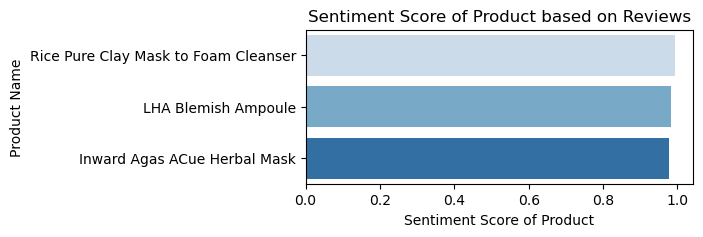

In [54]:
# set figure size
plt.rcParams['figure.figsize'] = (5,2)
sns.color_palette("Blues", as_cmap=True)
sns.barplot(x =plot_df['sentiment_score'],  y= plot_df['product_name'], data = plot_df, palette=("Blues"))

plt.xlabel("Sentiment Score of Product")
plt.ylabel("Product Name")
plt.title("Sentiment Score of Product based on Reviews")
# Show the plot
plt.show()

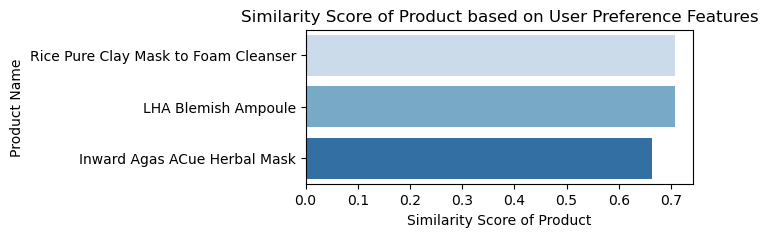

In [55]:
# set figure size
plt.rcParams['figure.figsize'] = (5,2)
sns.color_palette("Blues", as_cmap=True)
sns.barplot(x =plot_df['similarity_score'],  y= plot_df['product_name'], data = plot_df, palette=("Blues"))

plt.xlabel("Similarity Score of Product")
plt.ylabel("Product Name")
plt.title("Similarity Score of Product based on User Preference Features")
# Show the plot
plt.show()

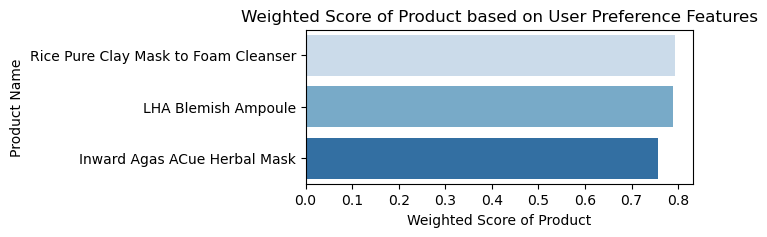

In [56]:
# set figure size
plt.rcParams['figure.figsize'] = (5,2)
sns.color_palette("Blues", as_cmap=True)
sns.barplot(x =plot_df['weighted_score'],  y= plot_df['product_name'], data = plot_df, palette=("Blues"))

plt.xlabel("Weighted Score of Product")
plt.ylabel("Product Name")
plt.title("Weighted Score of Product based on User Preference Features")
# Show the plot
plt.show()

In [57]:
#to check if the feature exist
#x = "hydration" in cv_dataframe

List of User preference

In [58]:
Skin_Concern = ["acne", "aging", "dehydration","clogged Pores", "pigmentation", "sensitive", "redness", "uneven skintone", "dryness"]
Product_Type = ["Cleanser", "Mask", "Toner", "Moisturizer,Serum","Other/Spot Treatments","Essence",
                "Sheet Mask","Eye Treatment","Sun Protection","Exfoliator","Lip Treatment"]
Skin_Type = ["oily", "dry", "combination", "normal"]
Price_Range = ["$0-$20", "$21-$40", "$41-$60", "$61-$80"]
Skin Goals = ["unclogged pores", "minimize pores", "reduce fine lines", "remove blackheads", "remove dark spots", 
              "improve skin texture","reduce pigmentation", "soft skin", "hydration", "detox", "smooth skin", "skin brightening","skin glow"]

In [51]:
cosine_similarity

0.816496580927726

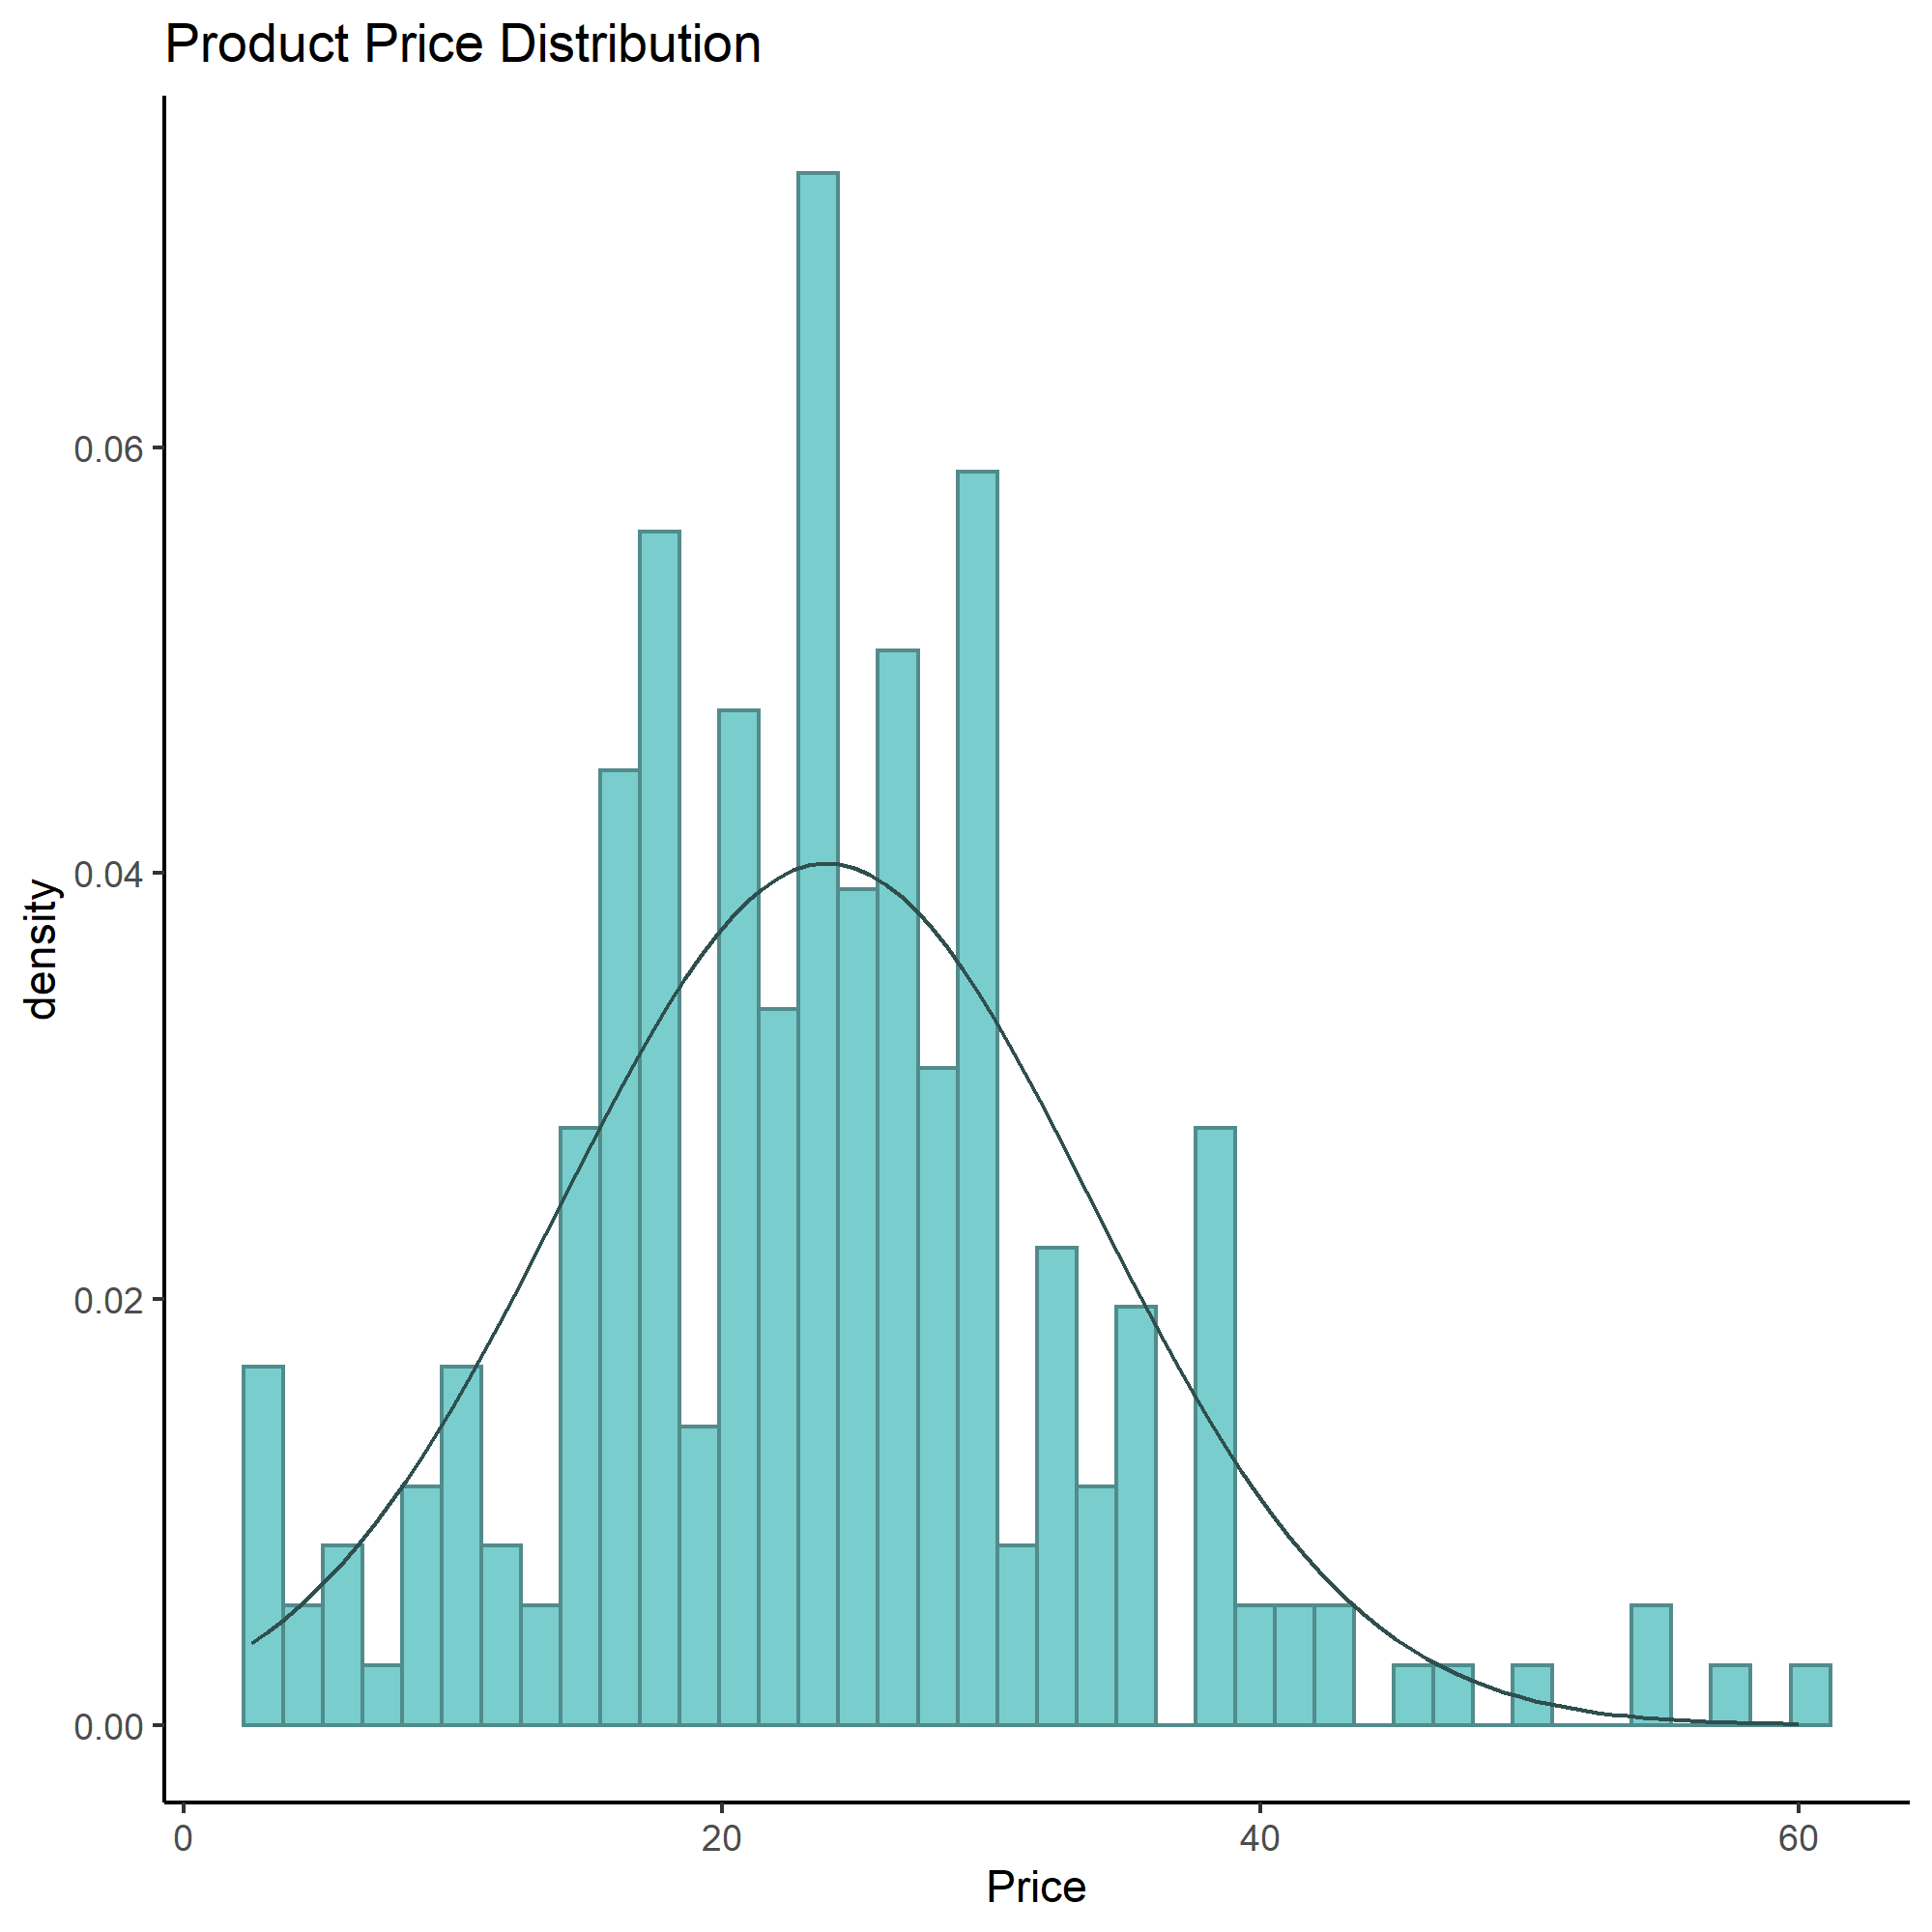

In [105]:
from IPython.display import Image
Image(filename='histogram_price.png')